# Set up

## Packages

In [1]:
using Random, Distributions, Plots, Integrals, DataFrames, StatsBase

# Julia translation of code from two youtube videos:
# https://www.youtube.com/watch?v=KmqTrm-bn8k and 
# https://www.youtube.com/watch?v=MNHIbOqH3sk&list=TLPQMDExMDIwMjP38Cg_Qmqw1g&index=2

### Defining distributions

In [2]:
#  Target distribution without normalisation constant
function f(x)
    (exp(-(x - 1) / 2) + exp(-(x - 1) ^ 2)) * (x >= 1) + 
    (x < 1) * (exp((x - 1) / 3) + exp((x - 1) ^ 3))
end
# candidate distribution
function g(x, μ = 0, σ = 1)
    pdf(Normal(μ, σ), x)
end

g (generic function with 3 methods)

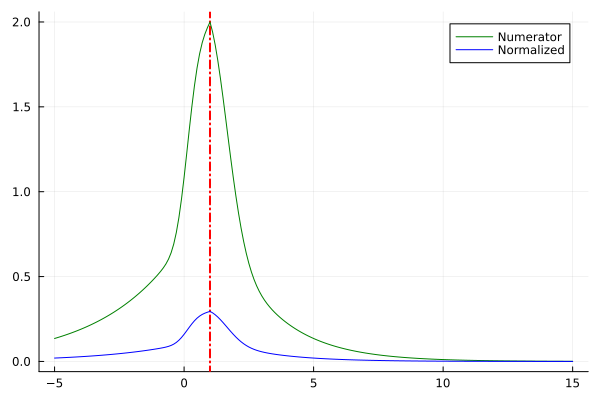

In [3]:
norm_const = solve(IntegralProblem((u, p) -> f(u), -Inf, Inf), 
                   HCubatureJL(); abstol = 1e-3).u
x_values = -5:.1:15

vline([1]; linestyle = :dashdot, linecolor = :red, linewidth = 2, legend = true, label = "")
plot!(x_values, [f.(x_values) f.(x_values) ./ norm_const]; linecolor = [:green :blue], label=["Numerator" "Normalized"])

In [4]:
true_expected_value = solve(IntegralProblem((u, p) -> u * f(u) / norm_const, -Inf, Inf), 
                            HCubatureJL(); abstol = 1e-3).u

0.26962236197418554

## Rejection sampling with $\mathcal{N}(1,4)$

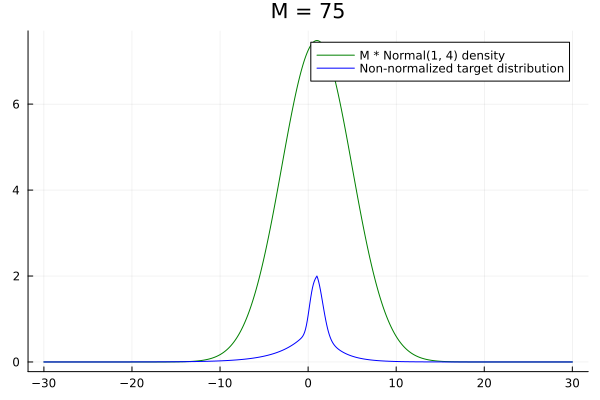

In [5]:
M = 75
x_values = -30:.1:30

plot(x_values, [M * g.(x_values, 1, 4) f.(x_values)]; 
    linecolor = [:green :blue], 
    label=["M * Normal(1, 4) density" "Non-normalized target distribution"], 
    title = "M = $M")

This isn't quite right but we *hope* it's a good enough approximation

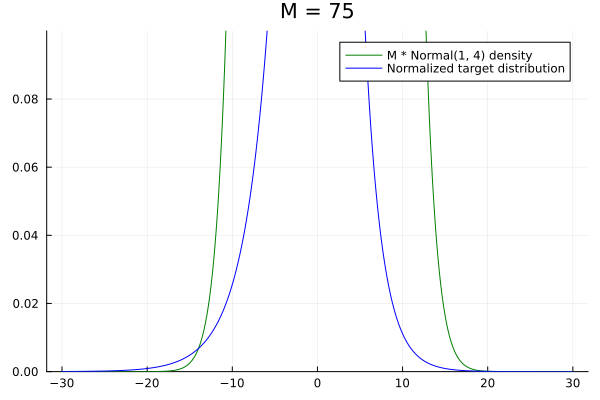

In [6]:
plot(x_values, [M * g.(x_values, 1, 4) f.(x_values)]; 
    linecolor = [:green :blue], 
    label=["M * Normal(1, 4) density" "Normalized target distribution"], 
    title = "M = $M",
    ylims = (0, .1))

In [7]:
N = 1_000_000
samples = []
@time begin
    for k in 1:N
        y = rand(Normal(1, 4))
        u = rand(Uniform(0, 1))
        if u < f(y) / (g(y, 1, 4) * M)
            push!(samples, y)
        end # end if
    end # end for
end # end time
@show length(samples)
println("Efficiency = $(100 * length(samples) / N)%");

  0.329618 seconds (8.09 M allocations: 140.515 MiB, 13.97% gc time)
length(samples) = 90045
Efficiency = 9.0045%


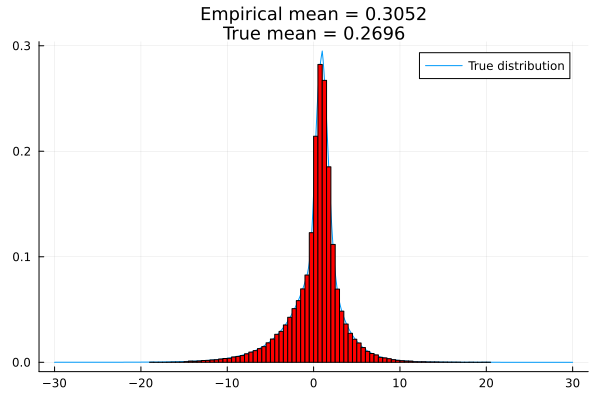

In [8]:
plot(x_values, [f.(x_values) / norm_const];
     title = "Empirical mean = $(round(mean(samples); digits = 4))\nTrue mean = $(round(true_expected_value; digits = 4))",
     titlefontsize = 12, label = "True distribution")
histogram!(samples; normalize = true, color = :red, bins = 100, label = "")

The tails are a little off

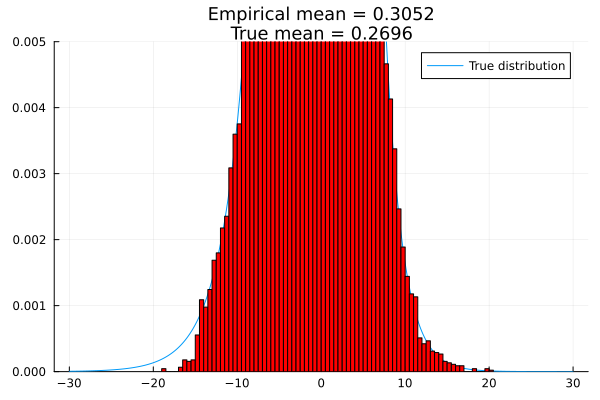

In [9]:
plot(x_values, [f.(x_values) / norm_const];
     title = "Empirical mean = $(round(mean(samples); digits = 4))\nTrue mean = $(round(true_expected_value; digits = 4))",
     titlefontsize = 12, label = "True distribution",
     ylims = (0, .005))
histogram!(samples; normalize = true, color = :red, bins = 100, label = "")

## Metropolis with $\mathcal{N}(x_{prev}, 4)$

In [10]:
@time begin
    samples = [1.0]
    accepted_num = 0
    for k in 1:N
        candidate = rand(Normal(samples[end], 4))
        probability_of_acceptance = min(1, f(candidate) / f(samples[end]))
    
        if rand(Uniform(0,1)) < probability_of_acceptance
            push!(samples, candidate)
            accepted_num += 1
        else
            push!(samples, samples[end])
        end # end if
    end # end for
end # end time
burn_in = 1000
samples_retained = samples[burn_in:end]
println("Efficiency = $(100 * length(samples_retained) / N)%")
println("Acceptance rate = $(100 * accepted_num / N)%")
println("Corelation with previously sampled value = $(autocor(samples_retained, [1]))");

  0.926232 seconds (15.53 M allocations: 277.787 MiB, 6.56% gc time, 1.34% compilation time)
Efficiency = 99.9002%
Acceptance rate = 48.5915%
Corelation with previously sampled value = [0.8056067437395911]


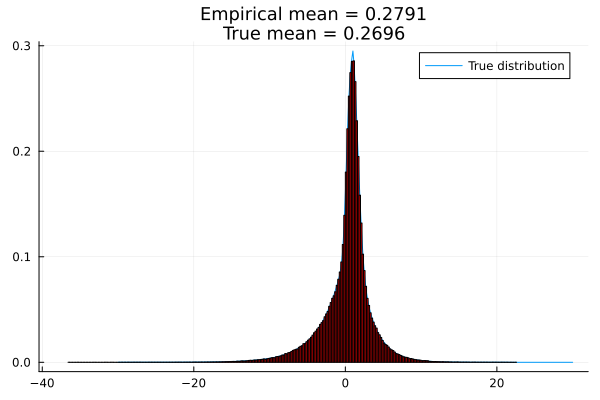

In [11]:
plot(x_values, [f.(x_values) / norm_const];
     title = "Empirical mean = $(round(mean(samples_retained); digits = 4))\nTrue mean = $(round(true_expected_value; digits = 4))",
     titlefontsize = 12, label = "True distribution")
histogram!(samples_retained; normalize = true, color = :red, bins = 300, label = "")

Much much better tail fit

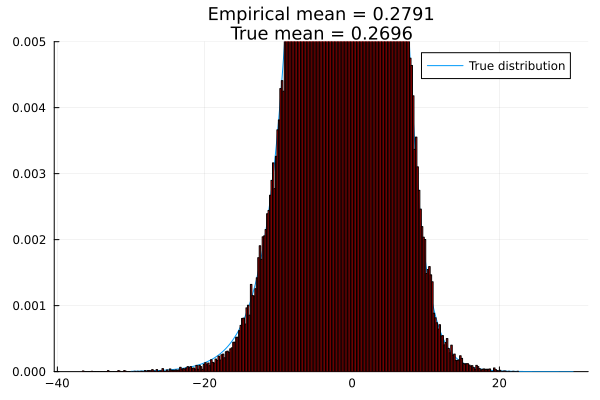

In [12]:
plot(x_values, [f.(x_values) / norm_const];
     title = "Empirical mean = $(round(mean(samples_retained); digits = 4))\nTrue mean = $(round(true_expected_value; digits = 4))",
     titlefontsize = 12, label = "True distribution", ylims = (0, .005))
histogram!(samples_retained; normalize = true, color = :red, bins = 300, label = "")

## Gibbs sampler for bivariate normal distribution

In [94]:
Σ = [1 0.5; 0.5 1]
μ = [0, 0]
biv_norm = MvNormal(μ, Σ)

FullNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0 0.5; 0.5 1.0]
)


In [103]:
# Vector of vectors beggining with initial values [1, -1]
samples = [[1.0, -1.0]]
N = 10000

for _ in 1:N
    x = rand(Normal(samples[end][2] / 2, sqrt(3/4)))
    y = rand(Normal(x[1] / 2, sqrt(3/4)))
    push!(samples, [x, y])
end # end for

In [104]:
sample_matrix = reduce(hcat, samples)'

10001×2 adjoint(::Matrix{Float64}) with eltype Float64:
  1.0        -1.0
 -1.20217    -0.725204
  1.21171    -0.160116
 -0.840789   -3.27486
 -0.0965169   0.993718
  2.00466     0.0467152
  0.897815    2.22756
  0.90884     1.32074
  0.265312    0.886941
 -0.754558   -0.960325
 -1.24927    -0.391189
 -1.38477     0.149772
  0.431409    0.0411039
  ⋮          
 -1.38012    -0.425004
  0.955857    0.396067
 -0.701511   -0.000168749
 -0.527978    1.33812
  0.0748755  -0.0533679
 -0.220894    0.956513
  0.413951    1.72027
  0.0149596   0.776849
  0.440893    1.7256
  0.280912   -0.0265278
 -0.813241   -0.897087
 -0.693078   -0.367288

In [105]:
@show Σ̂ = mean_and_cov(Matrix(sample_matrix))[2]
@show μ̂ = mean_and_cov(Matrix(sample_matrix))[1]
@show fit(MvNormal, sample_matrix');

Σ̂ = (mean_and_cov(Matrix(sample_matrix)))[2] = [0.9953566205225444 0.507883055953262; 0.507883055953262 1.018624237071979]
μ̂ = (mean_and_cov(Matrix(sample_matrix)))[1] = [0.013000504407503099 0.011972186073965205]
fit(MvNormal, sample_matrix') = FullNormal(
dim: 2
μ: [0.0130005044075031, 0.011972186073965194]
Σ: [0.9952570948130623 0.5078322727259894; 0.5078322727259894 1.018522384833496]
)



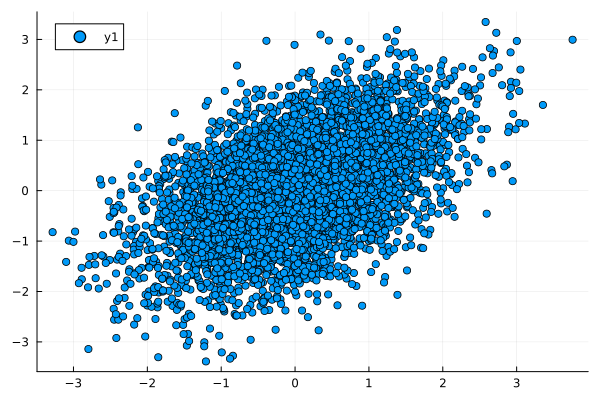

In [106]:
scatter(sample_matrix[1:5000, 1], sample_matrix[1:5000, 2])